# Project - Realtime Object Detection

## Importing Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

2025-06-15 14:24:43.226589: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 14:24:43.367353: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 14:24:43.494681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750011883.605805    1033 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750011883.636657    1033 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750011883.879016    1033 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Importing data

In [2]:
#Defining labels per dataset

# VisDrone categories of interest (ignore 0=ignored regions, 11=others)
visdrone_labels = {
    1: "pedestrian",
    2: "people",
    3: "bicycle",
    4: "car",
    5: "van",
    6: "truck",
    7: "tricycle",
    8: "awning-tricycle",
    9: "bus",
    10: "motor"
}

mot17_labels = {1: "pedestrian"}  # single-class

In [3]:
# --- Root directory for datasets ---
data_root = "../data"

# --- Training sequence definitions ---
train_folders = [
    {
        "dataset": "MOT17",
        "img_path": os.path.join(data_root, "MOT17/train/MOT17-04/img1"),
        "ann_path": os.path.join(data_root,"MOT17/train/MOT17-04/gt/gt.txt"),
        "type": "mot"
    },
    {
        "dataset": "VisDrone",
        "img_path": os.path.join(data_root, "VisDrone2019/train/sequences/uav0000366_00001_v"),
        "ann_path": os.path.join(data_root, "VisDrone2019/train/annotations/uav0000366_00001_v.txt"),
        "type": "visdrone"
    },
    {
        "dataset": "VisDrone",
        "img_path": os.path.join(data_root, "VisDrone2019/train/sequences/uav0000013_01073_v"),
        "ann_path": os.path.join(data_root, "VisDrone2019/train/annotations/uav0000013_01073_v.txt"),
        "type": "visdrone"
    }

    # Add more VisDrone sequences as needed
]


In [4]:
#Creating a unified load sequence with correct annotation parsing
def load_sequence(info):
    if info["type"] == "mot":
        img_dir = info["img_path"]
        gt_path = info["ann_path"]
        labels = mot17_labels
    elif info["type"] == "visdrone":
        img_dir = info["img_path"]
        gt_path = info["ann_path"]
        labels = visdrone_labels
    else:
        raise ValueError("Unsupported dataset type.")

    image_files = sorted([
        os.path.join(img_dir, f) for f in os.listdir(img_dir)
        if f.endswith('.jpg')
    ])

    annotations = {}

    with open(gt_path, 'r') as f:
        for line in f:
            fields = line.strip().split(',')
            if info["type"] == "mot":
                if len(fields) < 8:
                    continue
                try:
                    frame_id = int(fields[0])
                    x, y, w, h = map(float, fields[2:6])
                    mark = int(fields[6])
                    obj_class = int(float(fields[7]))
                except:
                    continue

                if mark != 1 or obj_class not in labels:
                    continue

            elif info["type"] == "visdrone":
                if len(fields) < 10:
                    continue
                try:
                    frame_id = int(fields[0])
                    x, y, w, h = map(float, fields[2:6])
                    score = int(float(fields[6]))
                    obj_class = int(float(fields[7]))
                except:
                    continue

                if obj_class not in labels or score != 1:
                    continue

            box = [x, y, x + w, y + h, obj_class]
            annotations.setdefault(frame_id, []).append(box)

    return image_files, annotations, labels

In [5]:
def show_frame_with_boxes(img_path, boxes, class_labels):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in boxes:
        x1, y1, x2, y2, cls = map(int, box)
        label = class_labels.get(cls, str(cls))
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

    plt.imshow(img)
    plt.axis('off')
    plt.show()


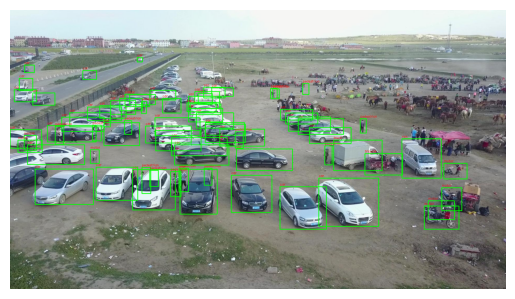

In [6]:
# Load a sequence (0 = MOT17, 1 = VisDrone)
sequence_info = train_folders[1]
img_files, annotations, labels = load_sequence(sequence_info)

# Show a frame
frame_id = 10
show_frame_with_boxes(img_files[frame_id], annotations.get(frame_id + 1, []), labels)


### Using Tensorflow for preprocessing the data

In [24]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
MAX_BOXES = 48

# --- Step 1: Define preprocessing function ---
def preprocess_image_and_boxes(img_path, boxes):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    orig_shape = tf.shape(img)[:2]

    # Resize and normalize
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0

    # Convert to tensor
    boxes = tf.convert_to_tensor(boxes, dtype=tf.float32)

    # Rescale boxes
    scale_y = tf.cast(IMG_SIZE[0], tf.float32) / tf.cast(orig_shape[0], tf.float32)
    scale_x = tf.cast(IMG_SIZE[1], tf.float32) / tf.cast(orig_shape[1], tf.float32)
    
    boxes_scaled = tf.stack([
        boxes[:, 0] * scale_x,
        boxes[:, 1] * scale_y,
        boxes[:, 2] * scale_x,
        boxes[:, 3] * scale_y,
        boxes[:, 4]  # class ID
    ], axis=1)

    return img, boxes_scaled

In [25]:
# --- Step 2: Prepare image paths and boxes ---
all_img_paths = []
all_boxes = []
all_classes = set()

# train_folders is assumed to be defined already
for seq_info in train_folders:
    img_files, annotations, labels = load_sequence(seq_info)

    for frame_id, frame_path in enumerate(img_files):
        frame_key = frame_id + 1
        boxes = annotations.get(frame_key, [])
        if boxes:
            all_img_paths.append(frame_path)
            all_boxes.append(boxes)
            for box in boxes:
                all_classes.add(int(box[4]))

In [26]:
# --- Step 3: Normalize class IDs to 0-based continuous IDs ---
original_ids = sorted(list(all_classes))
class_id_map = {orig_id: new_id for new_id, orig_id in enumerate(original_ids)}
NUM_CLASSES = len(class_id_map)

# --- Step 4: Dataset generator ---
def generator():
    for img_path, box_list in zip(all_img_paths, all_boxes):
        new_box_list = []
        for box in box_list[:MAX_BOXES]:  # clip to MAX_BOXES
            new_box = box[:4] + [class_id_map[int(box[4])]]
            new_box_list.append(new_box)
        yield img_path, new_box_list

dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(None, 5), dtype=tf.float32)
    )
)

# --- Step 5: Apply preprocessing ---
dataset = dataset.map(preprocess_image_and_boxes, num_parallel_calls=tf.data.AUTOTUNE)

# --- Step 6: Pad, batch, prefetch ---
dataset = dataset.shuffle(512).padded_batch(
    BATCH_SIZE,
    padded_shapes=([IMG_SIZE[0], IMG_SIZE[1], 3], [MAX_BOXES, 5]),
    padding_values=(0.0, 0.0)
).prefetch(tf.data.AUTOTUNE)

def format_for_model(img, boxes_with_labels):
    bboxes = boxes_with_labels[:, :, :4]  # shape: [batch, max_boxes, 4]
    class_ids = boxes_with_labels[:, :, 4]  # shape: [batch, max_boxes]
    return img, {"bbox": bboxes, "class_logits": class_ids}

train_dataset = dataset.map(format_for_model)

In [27]:
# Optional: print sample batch
for images, boxes in dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Boxes batch shape:", boxes.shape)  # [batch_size, MAX_BOXES, 5]

Image batch shape: (8, 224, 224, 3)
Boxes batch shape: (8, 48, 5)


2025-06-15 14:33:43.544076: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Building a custom CNN model

In [28]:
def custom_detector(input_shape = (224,224,3), max_boxes=48, num_classes=11):
    inputs = layers.Input(shape=input_shape)

    #Conv layer
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(512, activation="relu")(x)

    #Final output layer
    x = layers.Dense(max_boxes*(4 + num_classes))(x)
    x = layers.Reshape((max_boxes, 4 + num_classes))(x)

    #Split into two heads
    bbox_out = layers.Lambda(lambda t: t[:, :, :4], name="bbox")(x)            # shape: (batch, max_boxes, 4)
    class_out = layers.Lambda(lambda t: t[:, :, 4:], name="class_logits")(x)   # shape: (batch, max_boxes, num_classes)

    return models.Model(inputs=inputs, outputs=[bbox_out, class_out])



In [29]:
#Loss Setup
losses = {
    "bbox": tf.keras.losses.MeanSquaredError(),
    "class_logits": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
}


In [30]:
model = custom_detector(
    input_shape=(224, 224, 3),
    max_boxes=48,
    num_classes=NUM_CLASSES  # e.g., 11 for your unified labels
)

model.compile(optimizer="adam", loss=losses)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 224, 224,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 112, 112,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_8[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │     66,048 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 528)       │    270,864 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 48, 11)    │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox (Lambda)       │ (None, 48, 4)     │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_logits        │ (None, 48, 7)     │          0 │ reshape_2[0][0]   │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 430,160 (1.64 MB)

 Trainable params: 430,160 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
train_dataset = train_dataset.repeat()

model.fit(train_dataset, epochs=10, steps_per_epoch=176)

Epoch 1/10


176/176 ━━━━━━━━━━━━━━━━━━━━ 48s 262ms/step - bbox_loss: 2263.2617 - class_logits_loss: 0.1291 - loss: 2263.3962
Epoch 2/10


2025-06-15 14:45:51.917293: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 4824576 bytes after encountering the first element of size 4824576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


176/176 ━━━━━━━━━━━━━━━━━━━━ 46s 254ms/step - bbox_loss: 2178.2690 - class_logits_loss: 0.1097 - loss: 2178.3787
Epoch 3/10


2025-06-15 14:46:37.543839: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 4824576 bytes after encountering the first element of size 4824576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


176/176 ━━━━━━━━━━━━━━━━━━━━ 47s 260ms/step - bbox_loss: 2215.6936 - class_logits_loss: 0.0835 - loss: 2215.7778
Epoch 4/10


2025-06-15 14:47:24.244773: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 4824576 bytes after encountering the first element of size 4824576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


176/176 ━━━━━━━━━━━━━━━━━━━━ 48s 269ms/step - bbox_loss: 2241.5938 - class_logits_loss: 0.1065 - loss: 2241.7073
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 253ms/step - bbox_loss: 2248.3354 - class_logits_loss: 0.0856 - loss: 2248.4080
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 244ms/step - bbox_loss: 2225.4934 - class_logits_loss: 0.0650 - loss: 2225.5566
Epoch 7/10


2025-06-15 14:49:41.047961: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 4824576 bytes after encountering the first element of size 4824576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


176/176 ━━━━━━━━━━━━━━━━━━━━ 43s 245ms/step - bbox_loss: 2259.5693 - class_logits_loss: 0.0584 - loss: 2259.6467
Epoch 8/10


2025-06-15 14:50:24.176818: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 4824576 bytes after encountering the first element of size 4824576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


176/176 ━━━━━━━━━━━━━━━━━━━━ 46s 259ms/step - bbox_loss: 2223.4963 - class_logits_loss: 0.0692 - loss: 2223.5884
Epoch 9/10


2025-06-15 14:51:10.419301: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 4824576 bytes after encountering the first element of size 4824576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 245ms/step - bbox_loss: 2246.9353 - class_logits_loss: 0.0550 - loss: 2246.9817
Epoch 10/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 247ms/step - bbox_loss: 2194.3853 - class_logits_loss: 0.0556 - loss: 2194.4541
